In [2]:
pip install ruptures

     ------------------------------------- 381.3/381.3 kB 49.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import os
import numpy as np
import pandas as pd
import ruptures as rpt
import time
from tqdm import tqdm

import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from nas_environment import Environment

In [4]:
precomputed_logs_path = '../nas-bench-nlp-release/train_logs_single_run/'

In [16]:
precomputed_logs_path = "C:/Users/makov/OneDrive/Desktop/nas-bench-nlp-release/train_logs_single_run"#'../nas-bench-nlp-release/train_logs_single_run/'
env = Environment(precomputed_logs_path)
len(env._logs)

search_set = env.get_precomputed_recepies()
len(search_set)

14322

In [18]:
train_epochs = 10
rounds = 5
iters_per_round = 100
env.simulated_train(search_set[1], train_epochs)

# Embedings

In [22]:
%load_ext autoreload
%autoreload 2

import json
from tqdm.auto import tqdm
from pathlib import Path
import plotting
import networkx as nx 
from joblib import Parallel, delayed
import contextlib
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from copy import deepcopy
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hashlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def make_graph(recepie):
    G = nx.DiGraph()

    for key in recepie.keys():
        op = recepie[key]['op']
        if key.startswith("h_new_"):
            op = key+":"+op
        G.add_node(key, name=key, op=op)
        for inp in recepie[key]['input']:
            if "h_prev" in inp or inp == "x":
                G.add_node(inp, name=inp, op=inp)
            else:
                G.add_node(inp, name=inp)
            G.add_edge(inp, key)
    return 

In [24]:
# https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback:
        def __init__(self, time, index, parallel):
            self.index = index
            self.parallel = parallel

        def __call__(self, index):
            tqdm_object.update()
            if self.parallel._original_iterator is not None:
                self.parallel.dispatch_next()

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close() 

In [25]:
logs_path = Path(precomputed_logs_path)
logs_paths = list(logs_path.glob("*.json"))

logs_ok = []
logs_not_ok = []
for idx, log_path in tqdm(enumerate(logs_paths), total=len(logs_paths)):
    with open(log_path, "r") as f:
        log = json.load(f)
    recepie = json.loads(log['recepie'])
    log['recepie'] = recepie
    log['idx'] = idx
    
    if log['status'] == 'OK':
        logs_ok.append(log)
    else:
        logs_not_ok.append(log)

  0%|          | 0/14322 [00:00<?, ?it/s]

In [26]:
print("number ok: ", len(logs_ok))
print("number not ok: ", len(logs_not_ok))
print(len(logs_not_ok)/len(logs_ok))

number ok:  11598
number not ok:  2724
0.23486808070356957


In [27]:
def map_node(x):
    for v in ['node', 'h_prev', 'h_new']:
        if x.find(v) != -1:
            x = v
    if x not in ['x', 'node', 'h_prev', 'h_new']: # to make lstm and gru recepies standard
        x = 'node'
    return x

def make_graph_2(recepie):
    
    G = nx.DiGraph()
    for n in recepie.keys():
        if n not in G.nodes():
            G.add_node(n)
        for k in recepie[n]['input']:
            if k not in G.nodes():
                G.add_node(k)
            G.add_edge(n, k, label=recepie[n]['op'])
            G.add_edge(k, n, label='rev_' + recepie[n]['op'])
    return G

def random_walk_features(G, steps=10):
    walk = []
    node = np.random.choice(G.nodes(), 1)[0]
    for _ in range(steps):
        k = np.random.choice(list(G.adj[node]), 1)[0]
        walk.extend([map_node(node), G.adj[node][k]['label']])
        node = k
    walk.append(map_node(node))
    return walk

def make_graph_sentences(G, sentences_num=20):
    sentences = []
    for _ in range(sentences_num):
        sentences.extend(random_walk_features(G) + ['.'])
    return sentences

def feature_extractor(log):
    name = f"log_{log['idx']}"
    recepie = log['recepie']
    G = make_graph_2(recepie)
    doc = TaggedDocument(words=make_graph_sentences(G), tags=[name])
    return doc

In [28]:
document_collections = Parallel(n_jobs=-2)(delayed(feature_extractor)(log) for log in tqdm(logs_not_ok+logs_ok))

  0%|          | 0/14322 [00:00<?, ?it/s]

In [44]:
# takes a while!!
size = 10
# size = 50
doc2vec_model = Doc2Vec(document_collections, 
                        vector_size=size, window=3, dm=1, min_count=0, workers=8, epochs=100, hs=1,
                        dbow_words=0)

In [45]:
all_words = set()
for d in document_collections:
    all_words |= set(d.words)
len(all_words)

19

In [46]:
not_dublicates_ok_logs = []
not_dublicates_not_ok_logs = []
not_dublicates_recepies = []
for log in logs_not_ok+logs_ok:
    recepie = log['recepie']
    if recepie not in not_dublicates_recepies:
        not_dublicates_recepies.append(recepie)
        if log['status'] == 'OK':
            not_dublicates_ok_logs.append(log)
        else:
            not_dublicates_not_ok_logs.append(log)
print("total: ", len(logs_not_ok+logs_ok))
print("without dublicates: ", len(not_dublicates_ok_logs+not_dublicates_not_ok_logs))

total:  14322
without dublicates:  14322


In [47]:
#dump vectors
recepie_id_vectors = {log['recepie_id']:doc2vec_model.docvecs[f"log_{log['idx']}"]
                      for log in not_dublicates_ok_logs+not_dublicates_not_ok_logs}

C:\Users\makov\AppData\Local\Temp\ipykernel_11104\1374018668.py:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  recepie_id_vectors = {log['recepie_id']:doc2vec_model.docvecs[f"log_{log['idx']}"]


In [48]:
recepie_id_vectors_list = []
for k in recepie_id_vectors:
    k_dict = {'recepie_id':k}
    for i in range(doc2vec_model.vector_size):
        k_dict[f'v{i:02d}'] = recepie_id_vectors[k][i]
    recepie_id_vectors_list.append(k_dict)

In [49]:

df_recepie_vectors = pd.DataFrame(recepie_id_vectors_list)
df_recepie_vectors.head()

if size == 50:
    df_recepie_vectors.to_csv('data/embeddings/doc2vec_features.csv', index=False)
elif size == 10:
    df_recepie_vectors.to_csv('data/embeddings/doc2vec_features_lowdim.csv', index=False)

df_recepie_vectors = pd.read_csv('data/embeddings/doc2vec_features_lowdim.csv').set_index('recepie_id')

In [50]:
df_recepie_vectors

,v00,v01,v02,v03,v04,v05,v06,v07,v08,v09
recepie_id,,,,,,,,,,
1000000,-0.939227,-1.326254,-3.595356,6.325529,-1.249955,5.205863,-0.952345,-0.624317,1.810406,0.637260
1000001,-4.494163,0.320416,2.084035,2.834431,-0.404424,0.174602,-2.670208,0.952277,1.026880,4.952738
1000002,0.879933,-1.064102,-2.453569,1.620984,2.829320,-3.126456,-2.870428,-0.444996,1.277443,2.701715
1000009,-0.274049,0.121199,-0.197928,3.523049,-2.517979,2.726851,0.940322,2.665760,1.659498,-3.013063
1000011,0.221436,-0.129392,-0.780951,5.071681,-0.969125,4.010335,0.938837,1.854391,1.749977,-2.222422
...,...,...,...,...,...,...,...,...,...,...
2011766,0.831315,-0.720667,-3.210642,0.985734,1.406955,-4.060678,-3.986736,0.065571,1.465307,2.727388
2011788,-6.026748,-0.654352,3.393419,-2.793123,0.300454,0.674568,-2.398175,1.500771,0.346216,3.760246
2011790,-4.112630,0.680821,3.341045,-2.453108,0.184496,0.833579,0.788799,1.040817,1.258153,-1.425760


In [51]:
trainset_list = [
    (df_recepie_vectors.loc[log['recepie_id']], int(log['status'] == 'OK'))
    for log in not_dublicates_ok_logs+not_dublicates_not_ok_logs
]

random.shuffle(trainset_list)

trainset_np, testset_np = np.array(trainset_list[:7000]), np.array(trainset_list[7000:])
train_X, train_y = np.array(list(trainset_np[:, 0])), np.array(list(trainset_np[:, 1]))
test_X, test_y = np.array(list(testset_np[:, 0])), np.array(list(testset_np[:, 1]))

print("Train:", len(trainset_np))
print("Test: ", len(testset_np))

num_train_not_ok = len(train_y) - train_y.sum()
print("\nTrain OK: ", train_y.sum())
print("Train not OK: ", num_train_not_ok)

num_test_not_ok = len(test_y) - test_y.sum()
print("\nTest OK: ", test_y.sum())
print("Test not OK: ", num_test_not_ok)

Train: 7000
Test:  7322

Train OK:  5698
Train not OK:  1302

Test OK:  5900
Test not OK:  1422


C:\Users\makov\AppData\Local\Temp\ipykernel_11104\2802381340.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trainset_np, testset_np = np.array(trainset_list[:7000]), np.array(trainset_list[7000:])


In [52]:
tsne = TSNE(n_components=2, n_iter=300, verbose=True)

In [53]:
E = tsne.fit_transform(train_X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.004s...
[t-SNE] Computed neighbors for 7000 samples in 0.295s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 1.017225
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.394348
[t-SNE] KL divergence after 300 iterations: 2.234656


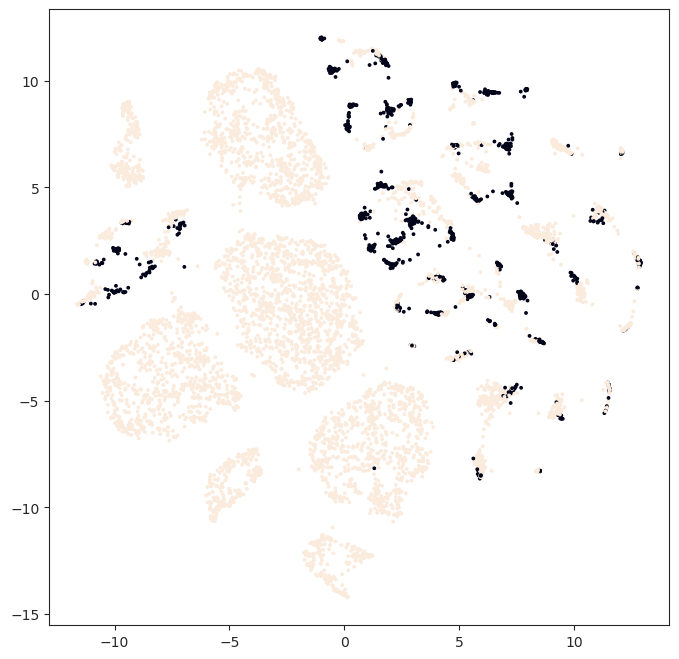

In [54]:
plt.figure(figsize=(8, 8))
plt.scatter(E[:, 0], E[:, 1], s=3, c=train_y)

In [55]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [56]:
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc 

In [57]:
model = XGBClassifier(n_jobs=-1)
model.fit(train_X, train_y)

pred_y = model.predict_proba(test_X)
precision_xgboost, recall_xgboost, _ = precision_recall_curve(test_y, pred_y[:, 1])
fpr_xgboost, tpr_xgboost, _ = roc_curve(test_y, pred_y[:, 1])
roc_auc_axboost = auc(fpr_xgboost, tpr_xgboost)

f1_test_score = f1_score(test_y, np.argmax(pred_y, 1))
ap_test_score = average_precision_score(test_y, pred_y[:, 1])
print("XGBoost F1 score: ", f1_test_score)
print("XGBoost Average Precision score: ", ap_test_score)

XGBoost F1 score:  0.9832449271701608
XGBoost Average Precision score:  0.9977090736378773


In [58]:
trainset_list = [
    (doc2vec_model.docvecs[f"log_{log['idx']}"], np.array(log['val_losses']).min())
    for log in not_dublicates_ok_logs
]


np.random.seed(0)
random.shuffle(trainset_list)

trainset_np, testset_np = np.array(trainset_list[:7000]), np.array(trainset_list[7000:])
train_X, train_y = np.array(list(trainset_np[:, 0])), np.array(list(trainset_np[:, 1]))
test_X, test_y = np.array(list(testset_np[:, 0])), np.array(list(testset_np[:, 1]))

print("Train:", len(trainset_np))
print("Test: ", len(testset_np))

num_train_not_ok = len(train_y) - train_y.sum()
print("\nTrain OK: ", train_y.sum())
print("Train not OK: ", num_train_not_ok)

num_test_not_ok = len(test_y) - test_y.sum()
print("\nTest OK: ", test_y.sum())
print("Test not OK: ", num_test_not_ok)

Train: 7000
Test:  4598

Train OK:  36098.26165287341
Train not OK:  -29098.261652873407

Test OK:  23748.162054422668
Test not OK:  -19150.162054422668


C:\Users\makov\AppData\Local\Temp\ipykernel_11104\3798520292.py:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  (doc2vec_model.docvecs[f"log_{log['idx']}"], np.array(log['val_losses']).min())
C:\Users\makov\AppData\Local\Temp\ipykernel_11104\3798520292.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trainset_np, testset_np = np.array(trainset_list[:7000]), np.array(trainset_list[7000:])


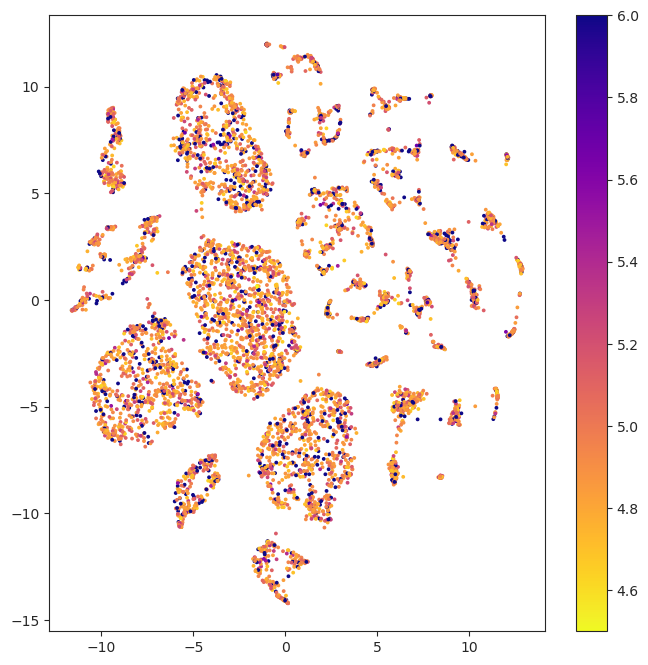

In [59]:
plt.figure(figsize=(8, 8))
plt.scatter(E[:, 0], E[:, 1], s=3, c=train_y, cmap=plt.cm.plasma_r)
plt.colorbar()
plt.clim([4.5, 6])

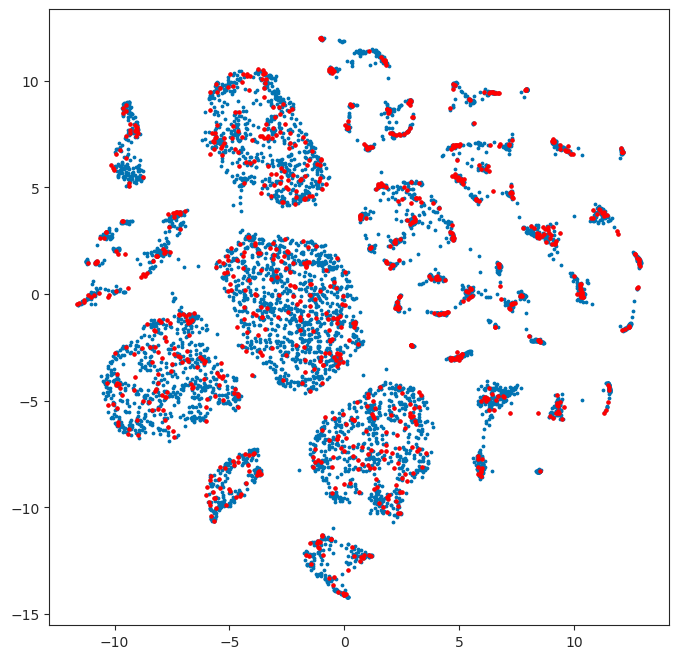

In [60]:

plt.figure(figsize=(8, 8))
plt.scatter(E[:, 0], E[:, 1], s=3, color='C0')
sub_inds = np.where(train_y > 6)[0]
plt.scatter(E[sub_inds, 0], E[sub_inds, 1], s=5, color='red')

In [61]:
model = XGBClassifier(n_jobs=-1)
model.fit(train_X, train_y > 6)

pred_y = model.predict_proba(test_X)
precision_xgboost, recall_xgboost, _ = precision_recall_curve(test_y > 6, pred_y[:, 1])
fpr_xgboost, tpr_xgboost, _ = roc_curve(test_y > 6, pred_y[:, 1])
roc_auc_axboost = auc(fpr_xgboost, tpr_xgboost)

f1_test_score = f1_score(test_y > 6, np.argmax(pred_y, 1))
ap_test_score = average_precision_score(test_y > 6, pred_y[:, 1])
print("XGBoost F1 score: ", f1_test_score)
print("XGBoost Average Precision score: ", ap_test_score)

XGBoost F1 score:  0.18757062146892656
XGBoost Average Precision score:  0.28601819321167465


In [62]:
min_loss = min(train_y)

28


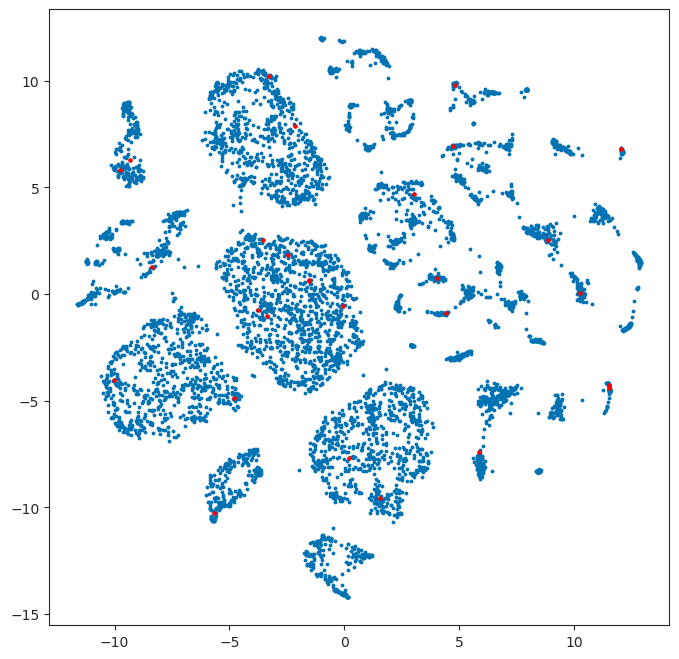

In [63]:
betta = 1.05
sub_inds = np.where(train_y < betta * min_loss)[0]
print(len(sub_inds))

plt.figure(figsize=(8, 8))
plt.scatter(E[:, 0], E[:, 1], s=3, color='C0')
plt.scatter(E[sub_inds, 0], E[sub_inds, 1], s=5, color='red')

In [64]:
model = XGBClassifier(n_jobs=-1)
model.fit(train_X, train_y < betta * min_loss)

pred_y = model.predict_proba(test_X)
precision_xgboost, recall_xgboost, _ = precision_recall_curve(test_y < betta * min_loss, pred_y[:, 1])
fpr_xgboost, tpr_xgboost, _ = roc_curve(test_y < betta * min_loss, pred_y[:, 1])
roc_auc_axboost = auc(fpr_xgboost, tpr_xgboost)

f1_test_score = f1_score(test_y < betta * min_loss, np.argmax(pred_y, 1))
ap_test_score = average_precision_score(test_y < betta * min_loss, pred_y[:, 1])
print("XGBoost F1 score: ", f1_test_score)
print("XGBoost Average Precision score: ", ap_test_score)

XGBoost F1 score:  0.0
XGBoost Average Precision score:  0.015522687417815614


# GP

In [65]:
df_recepie_vectors = pd.read_csv('data/embeddings/doc2vec_features_lowdim.csv').set_index('recepie_id')
df_recepie_vectors

,v00,v01,v02,v03,v04,v05,v06,v07,v08,v09
recepie_id,,,,,,,,,,
1000000,-0.939227,-1.326254,-3.595356,6.325529,-1.249955,5.205863,-0.952345,-0.624317,1.810406,0.637260
1000001,-4.494163,0.320416,2.084035,2.834431,-0.404424,0.174602,-2.670208,0.952277,1.026880,4.952738
1000002,0.879933,-1.064102,-2.453569,1.620984,2.829320,-3.126456,-2.870428,-0.444996,1.277443,2.701715
1000009,-0.274049,0.121199,-0.197928,3.523049,-2.517979,2.726851,0.940322,2.665760,1.659498,-3.013063
1000011,0.221436,-0.129392,-0.780951,5.071681,-0.969125,4.010335,0.938837,1.854391,1.749977,-2.222422
...,...,...,...,...,...,...,...,...,...,...
2011766,0.831315,-0.720667,-3.210642,0.985734,1.406955,-4.060678,-3.986736,0.065571,1.465307,2.727388
2011788,-6.026748,-0.654352,3.393419,-2.793123,0.300454,0.674568,-2.398175,1.500771,0.346216,3.760246
2011790,-4.112630,0.680821,3.341045,-2.453108,0.184496,0.833579,0.788799,1.040817,1.258153,-1.425760


In [66]:
trainset_list = [
    (log['idx'], df_recepie_vectors.loc[log['recepie_id']], np.array(log['val_losses']))
    for log in not_dublicates_ok_logs
]

In [67]:
n = 10

X_train = np.arange(1, n+1).reshape(-1,1)
y_train = trainset_list[0][2][:n].reshape(-1,1)

X_test = np.arange(n+1, 51).reshape(-1,1)
y_test = trainset_list[0][2][n:].reshape(-1,1)

assert len(X_test) == len(y_test)
assert len(X_train) == len(y_train)

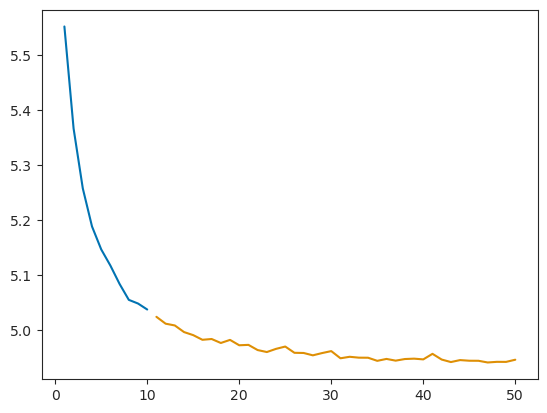

In [68]:
plt.plot(X_train, y_train)
plt.plot(X_test, y_test)

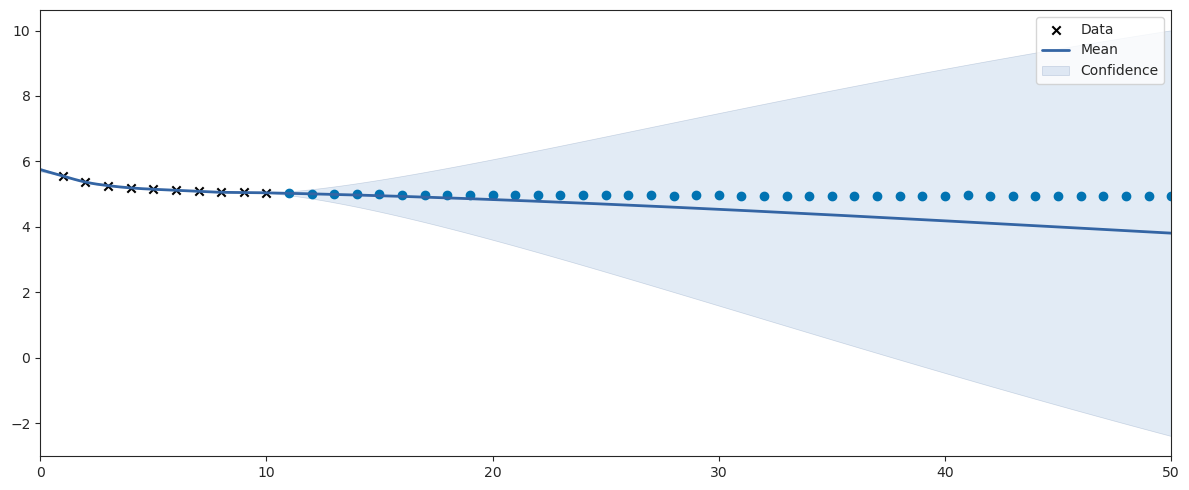

In [71]:
import GPy

kernel =  GPy.kern.src.stationary.Matern32(input_dim=1, variance=1.0)# + GPy.kern.RBF(input_dim=1, variance = 0.2)#  + GPy.kern.StdPeriodic(input_dim=1)
m = GPy.models.GPRegression(X_train, y_train, kernel)
m.optimize(messages=False)
fig = m.plot(figsize = (12, 5), plot_limits  = [0, 50])
plt.xlim([0, 50])
plt.scatter(X_test, y_test)

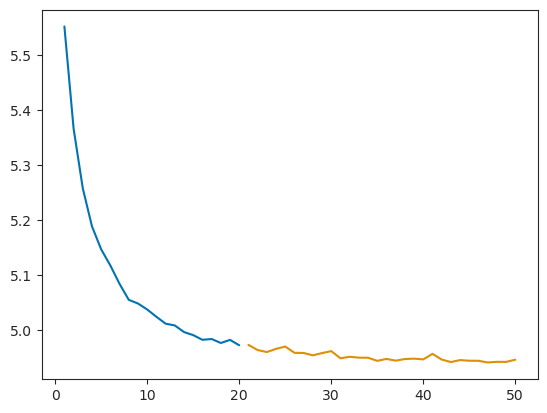

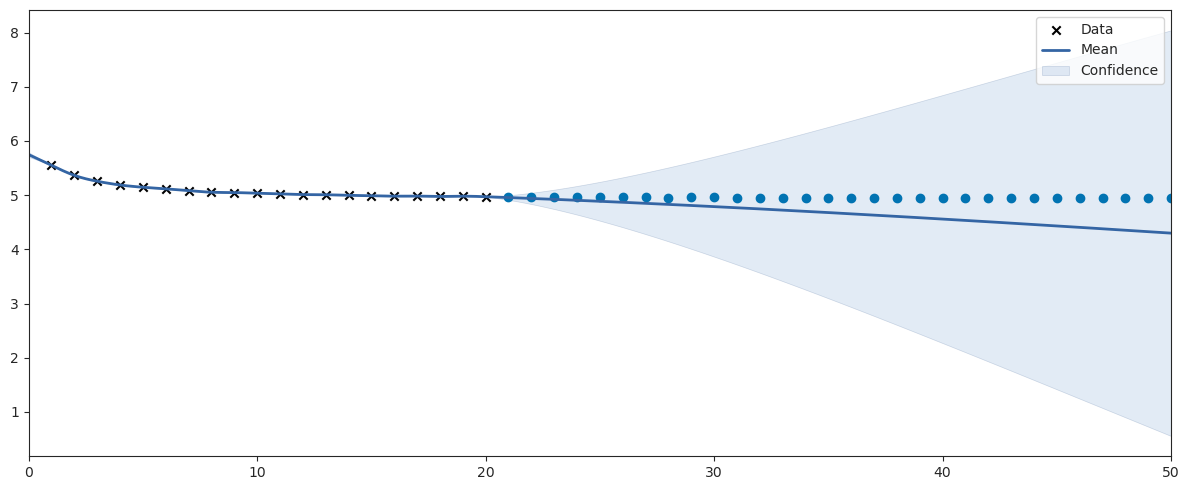

In [72]:
n = 20

X_train = np.arange(1, n+1).reshape(-1,1)
y_train = trainset_list[0][2][:n].reshape(-1,1)

X_test = np.arange(n+1, 51).reshape(-1,1)
y_test = trainset_list[0][2][n:].reshape(-1,1)

assert len(X_test) == len(y_test)
assert len(X_train) == len(y_train)

plt.plot(X_train, y_train)
plt.plot(X_test, y_test)
plt.show()


kernel =  GPy.kern.src.stationary.Matern32(input_dim=1, variance=1.0)
m = GPy.models.GPRegression(X_train, y_train, kernel)
m.optimize(messages=False)
fig = m.plot(figsize = (12, 5), plot_limits  = [0, 50])
plt.xlim([0, 50])
plt.scatter(X_test, y_test)

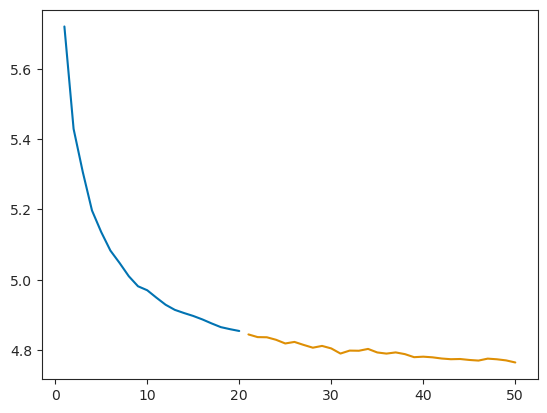

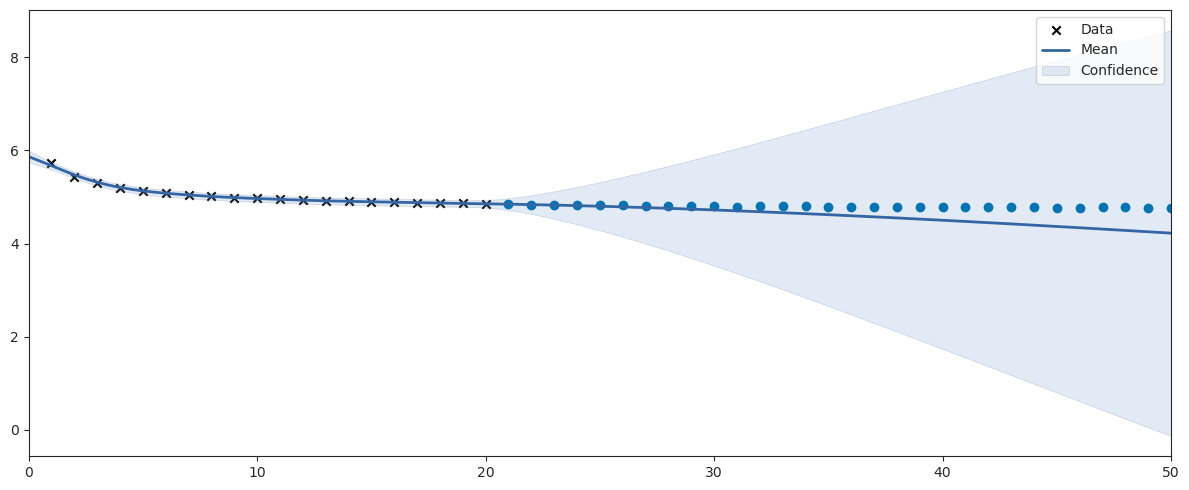

In [73]:
idx = 27
n = 20

X_train = np.arange(1, n+1).reshape(-1,1)
y_train = trainset_list[idx][2][:n].reshape(-1,1)

X_test = np.arange(n+1, 51).reshape(-1,1)
y_test = trainset_list[idx][2][n:].reshape(-1,1)

assert len(X_test) == len(y_test)
assert len(X_train) == len(y_train)

plt.plot(X_train, y_train)
plt.plot(X_test, y_test)
plt.show()


kernel = GPy.kern.src.stationary.Matern32(input_dim=1, variance=1.0)
m = GPy.models.GPRegression(X_train, y_train, kernel)
m.Gaussian_noise.variance.fix(0.001)
m.optimize(messages=False)
fig = m.plot(figsize = (12, 5), plot_limits  = [0, 50])
plt.xlim([0, 50])
plt.scatter(X_test, y_test)

In [74]:
from scipy.stats import norm

In [75]:
min_val_losses = [np.array(log['val_losses']).min() for log in not_dublicates_ok_logs]
min_loss = min(min_val_losses)
min_loss


4.408801641949153

In [76]:
threshold_loss = min_loss * 1.05
threshold_loss

4.629241724046611

In [77]:
last_val_losses = [np.array(log['val_losses'])[-1] for log in not_dublicates_ok_logs]

In [78]:
num_of_appropriate = 0
for loss in last_val_losses:
    if loss < threshold_loss:
        num_of_appropriate += 1

In [79]:
f"{num_of_appropriate / len(last_val_losses) * 100} %"

'0.3707535782031385 %'

In [80]:
len(last_val_losses) 

11598

In [81]:
n = 20
result = []

for log in tqdm(not_dublicates_ok_logs):
    
    idx = log['idx']
    X_train = np.arange(1, n+1).reshape(-1,1)
    y_train = np.array(log['val_losses'])[:n].reshape(-1,1)

    kernel = GPy.kern.src.stationary.Matern32(input_dim=1, variance=1.0)
    m = GPy.models.GPRegression(X_train, y_train, kernel)
    m.Gaussian_noise.variance.fix(0.001)
    m.optimize(messages=False)
    prediction_mean, prediction_var = m.predict(np.array([[50]]))
    prediction_std = np.sqrt(prediction_var).ravel()
    prediction_mean = prediction_mean.ravel()
    mean, std = prediction_mean[-1], prediction_std[-1]

    result.append((idx, norm.cdf((threshold_loss - mean) / std)))


  0%|          | 0/11598 [00:00<?, ?it/s]

 c:\Users\makov\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in divide
 c:\Users\makov\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:484: RuntimeWarning:overflow encountered in multiply
 c:\Users\makov\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:484: RuntimeWarning:invalid value encountered in multiply


In [82]:
np.mean(np.array(result)[:, 1])

0.4636609586760895

# пока неудачно

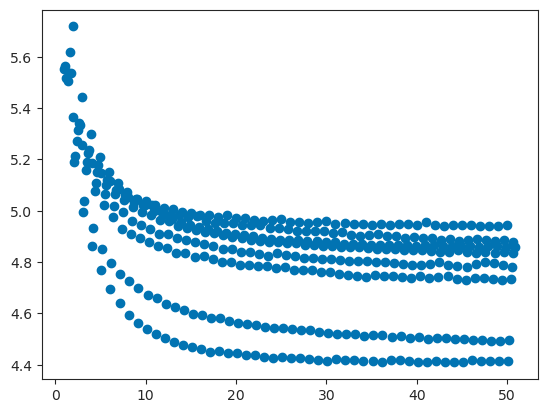

In [83]:
X = np.array([])
Y = np.array([])
for i in range(10):
    log = env._logs[i]
    #idx = log["recepie_idx"]
    loss = log["val_losses"]
    if loss[0] > 8 or loss[0] < 5.4:
        continue
    
    
    y = np.array(loss)#.reshape(-1,1)
    x = np.arange(1, len(y)+1) + 0.1 * i#.reshape(-1,1)

    Y = np.concatenate((Y, y))
    X = np.concatenate((X, x))

    assert len(x) == len(y)

X = X.reshape(-1,1)
Y = Y.reshape(-1,1)

plt.scatter(X, Y)

In [86]:
kernel = GPy.kern.RBF(input_dim=1)#  + GPy.kern.StdPeriodic(input_dim=1)
m = GPy.models.GPRegression(X, Y, kernel)
m.optimize(messages=False)
fig = m.plot(figsize = (12, 5))

LinAlgError: not positive definite, even with jitter.

In [85]:
m.predict(X)

(array([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

## Catboost

In [87]:
pip install catboost

     -------------------------------------- 101.0/101.0 MB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [100]:

np.array(not_dublicates_ok_logs[0]['val_losses']).shape

(50,)

In [105]:

n = 10
trainset_list = [
    (np.array(log['val_losses'][n]), np.array(log['val_losses']).min())
    for log in not_dublicates_ok_logs
]

np.random.seed(0)
random.shuffle(trainset_list)

trainset_np, testset_np = np.array(trainset_list[:7000]), np.array(trainset_list[7000:])
train_X, train_y = np.array(list(trainset_np[:, 0])), np.array(list(trainset_np[:, 1]))
test_X, test_y = np.array(list(testset_np[:, 0])), np.array(list(testset_np[:, 1]))

print("Train len:", len(trainset_np))
print("Test len: ", len(testset_np))

Train len: 7000
Test len:  4598


In [106]:
model = XGBClassifier(n_jobs=-1)
model.fit(train_X, train_y)

pred_y = model.predict_proba(test_X)
precision_xgboost, recall_xgboost, _ = precision_recall_curve(test_y, pred_y[:, 1])
fpr_xgboost, tpr_xgboost, _ = roc_curve(test_y, pred_y[:, 1])
roc_auc_axboost = auc(fpr_xgboost, tpr_xgboost)

f1_test_score = f1_score(test_y, np.argmax(pred_y, 1))
ap_test_score = average_precision_score(test_y, pred_y[:, 1])
print("XGBoost F1 score: ", f1_test_score)
print("XGBoost Average Precision score: ", ap_test_score)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 6933 6934 6935], got [4.49156151 4.52850338 4.57048961 ... 8.68834084 8.87132349 9.84387579]